In [20]:
# Cell 1: Imports and Configuration
import os
import torch
import h5py
import numpy as np
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt
import optuna
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, GATConv, knn_graph
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
K = 15
EPOCHS = 200
PATIENCE = 10  # Early stopping patience
OPTUNA_TRIALS = 20  # Number of Optuna trials

In [21]:
# Cell 2: Dataset Class Definition
class MusicGraphDataset(Dataset):
    def __init__(self, root, metadata_path, features_path):
        self.metadata_path = metadata_path
        self.features_path = features_path
        super().__init__(root)
        
    @property
    def processed_file_names(self):
        return ['data.pt', 'norm_params.pt']
    
    def process(self):
        # Load metadata and features
        df = pd.read_csv(self.metadata_path)
        with h5py.File(self.features_path, 'r') as f:
            features = torch.tensor(np.array(f['features']), dtype=torch.float32)
            labels = torch.tensor(np.array(f['labels']), dtype=torch.long)
        
        # Create stratified splits
        indices = torch.randperm(len(features))
        train_idx = indices[:int(0.8*len(indices))]
        val_idx = indices[int(0.8*len(indices)):int(0.9*len(indices))]
        test_idx = indices[int(0.9*len(indices)):]

        # Normalization
        X_min = features[train_idx].min()
        X_max = features[train_idx].max()
        features = (features - X_min) / (X_max - X_min + 1e-8)

        # Create graph
        edge_index = knn_graph(features, k=K)

        # Create masks
        train_mask = torch.zeros(len(features), dtype=bool)
        val_mask = torch.zeros(len(features), dtype=bool)
        test_mask = torch.zeros(len(features), dtype=bool)
        train_mask[train_idx] = True
        val_mask[val_idx] = True
        test_mask[test_idx] = True

        data = Data(
            x=features,
            edge_index=edge_index,
            y=labels,
            train_mask=train_mask,
            val_mask=val_mask,
            test_mask=test_mask
        )

        # Save processed data
        torch.save(data, osp.join(self.processed_dir, 'data.pt'))
        torch.save({'min': X_min, 'max': X_max}, 
                 osp.join(self.processed_dir, 'norm_params.pt'))

In [22]:
# Cell 3: Model Definitions
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_dim, dropout):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_dim, dropout, heads):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=heads)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim * heads)
        self.conv2 = GATConv(hidden_dim * heads, num_classes, heads=1, concat=False)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [29]:
# Cell 2: Update Optuna Objective Function to Handle OOM
def objective(trial):
    try:
        # Hyperparameters to optimize
        hidden_dim = trial.suggest_int('hidden_dim', 16, 64)  # Reduced max hidden_dim
        dropout = trial.suggest_float('dropout', 0.2, 0.5)
        lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
        heads = trial.suggest_int('heads', 2, 4) if MODEL_TYPE == 'gat' else 1  # Reduced max heads

        # Initialize dataset
        dataset = MusicGraphDataset(
            root='processed_data',
            metadata_path='nepali_music_metadata.csv',
            features_path='nepali_features.hdf5'
        )
        data = torch.load(osp.join(dataset.processed_dir, 'data.pt')).to(DEVICE)

        # Initialize model
        if MODEL_TYPE == 'gcn':
            model = GCN(data.num_features, 10, hidden_dim, dropout).to(DEVICE)
        else:
            model = GAT(data.num_features, 10, hidden_dim, dropout, heads).to(DEVICE)

        # Optimizer and scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

        # Training loop
        best_val_loss = float('inf')
        for epoch in range(EPOCHS):
            model.train()
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            # Validation
            model.eval()
            with torch.no_grad():
                out = model(data.x, data.edge_index)
                val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask]).item()
                scheduler.step(val_loss)

                # Early stopping
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_without_improvement = 0
                    # Save the best model
                    torch.save(model.state_dict(), f'best_{MODEL_TYPE}_trial_{trial.number}.pt')
                else:
                    epochs_without_improvement += 1
                    if epochs_without_improvement >= PATIENCE:
                        break

        # Clear memory
        del model, optimizer, scheduler
        torch.cuda.empty_cache()

        return best_val_loss

    except RuntimeError as e:
        if 'CUDA out of memory' in str(e):
            print(f"OOM error in trial {trial.number}. Skipping...")
            torch.cuda.empty_cache()
            return float('inf')  # Return a high loss to discard this trial
        else:
            raise e

In [30]:
# Cell 5: Run Optuna Optimization
def optimize_hyperparameters():
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=OPTUNA_TRIALS)

    # Save the best hyperparameters and model
    best_trial = study.best_trial
    print(f"Best trial: {best_trial.number}")
    print(f"Best validation loss: {best_trial.value:.4f}")
    print(f"Best hyperparameters: {best_trial.params}")

    # Rename the best model file
    best_model_path = f'best_{MODEL_TYPE}_trial_{best_trial.number}.pt'
    final_model_path = f'best_{MODEL_TYPE}.pt'
    os.rename(best_model_path, final_model_path)
    print(f"Best model saved to {final_model_path}")

# Run optimization for GCN
MODEL_TYPE = 'gcn'
optimize_hyperparameters()

# Run optimization for GAT
MODEL_TYPE = 'gat'
optimize_hyperparameters()

[I 2025-01-26 18:48:52,336] A new study created in memory with name: no-name-73f1fca0-485f-4d37-aa02-47f711cf4789
/tmp/ipykernel_13251/2887968249.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi

Best trial: 16
Best validation loss: 0.5535
Best hyperparameters: {'hidden_dim': 48, 'dropout': 0.35383540022461457, 'lr': 0.0059797792015148545, 'weight_decay': 3.398807978977328e-05}
Best model saved to best_gcn.pt


[I 2025-01-26 18:49:13,033] Trial 0 finished with value: 0.607587993144989 and parameters: {'hidden_dim': 57, 'dropout': 0.4259367630594231, 'lr': 0.0006053020338365133, 'weight_decay': 1.0399241217255609e-05, 'heads': 2}. Best is trial 0 with value: 0.607587993144989.
[I 2025-01-26 18:49:15,158] Trial 1 finished with value: 0.5707818865776062 and parameters: {'hidden_dim': 24, 'dropout': 0.341485248071941, 'lr': 0.0028413205322696086, 'weight_decay': 2.851478550278825e-05, 'heads': 4}. Best is trial 1 with value: 0.5707818865776062.
[I 2025-01-26 18:49:16,595] Trial 2 finished with value: 0.6851847171783447 and parameters: {'hidden_dim': 41, 'dropout': 0.4302787721796704, 'lr': 0.0052244943442277736, 'weight_decay': 5.732077384602792e-05, 'heads': 4}. Best is trial 1 with value: 0.5707818865776062.
[I 2025-01-26 18:49:19,215] Trial 3 finished with value: 0.6370624303817749 and parameters: {'hidden_dim': 42, 'dropout': 0.4449505888579305, 'lr': 0.00041850458787823756, 'weight_decay': 1

Best trial: 1
Best validation loss: 0.5708
Best hyperparameters: {'hidden_dim': 24, 'dropout': 0.341485248071941, 'lr': 0.0028413205322696086, 'weight_decay': 2.851478550278825e-05, 'heads': 4}
Best model saved to best_gat.pt


In [45]:
# Cell 1: Imports and Configuration
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Best hyperparameters for GAT
GAT_HYPERPARAMS = {
    'hidden_dim': 24,
    'dropout': 0.341485248071941,
    'lr': 0.0028413205322696086,
    'weight_decay': 2.851478550278825e-05,
    'heads': 4
}

# Best hyperparameters for GCN
GCN_HYPERPARAMS = {
    'hidden_dim': 48,
    'dropout': 0.35383540022461457,
    'lr': 0.0059797792015148545,
    'weight_decay': 3.398807978977328e-05
}

In [46]:
# Cell 2: GAT Model
class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GATConv(
            num_features,
            GAT_HYPERPARAMS['hidden_dim'],
            heads=GAT_HYPERPARAMS['heads']
        )
        self.bn1 = torch.nn.BatchNorm1d(GAT_HYPERPARAMS['hidden_dim'] * GAT_HYPERPARAMS['heads'])
        self.conv2 = GATConv(
            GAT_HYPERPARAMS['hidden_dim'] * GAT_HYPERPARAMS['heads'],
            num_classes,
            heads=1,
            concat=False
        )
        self.dropout = GAT_HYPERPARAMS['dropout']

    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [47]:
# Cell 3: GCN Model
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, GCN_HYPERPARAMS['hidden_dim'])
        self.bn1 = torch.nn.BatchNorm1d(GCN_HYPERPARAMS['hidden_dim'])
        self.conv2 = GCNConv(GCN_HYPERPARAMS['hidden_dim'], num_classes)
        self.dropout = GCN_HYPERPARAMS['dropout']

    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [48]:
# Cell 1: Plot Training and Validation Curves
import matplotlib.pyplot as plt

def plot_training_curves(gat_results, gcn_results):
    # Unpack results
    gat_train_losses, gat_train_accs, gat_val_losses, gat_val_accs = gat_results
    gcn_train_losses, gcn_train_accs, gcn_val_losses, gcn_val_accs = gcn_results

    # Create figure
    plt.figure(figsize=(15, 6))

    # Plot Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(gat_train_losses, label='GAT Train Loss', color='blue', linestyle='-')
    plt.plot(gat_val_losses, label='GAT Val Loss', color='blue', linestyle='--')
    plt.plot(gcn_train_losses, label='GCN Train Loss', color='orange', linestyle='-')
    plt.plot(gcn_val_losses, label='GCN Val Loss', color='orange', linestyle='--')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(gat_train_accs, label='GAT Train Acc', color='blue', linestyle='-')
    plt.plot(gat_val_accs, label='GAT Val Acc', color='blue', linestyle='--')
    plt.plot(gcn_train_accs, label='GCN Train Acc', color='orange', linestyle='-')
    plt.plot(gcn_val_accs, label='GCN Val Acc', color='orange', linestyle='--')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show() 

In [49]:
# Cell 2: Updated Training Function
def train_model(model, data, optimizer, scheduler):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        # Training
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Training metrics
        pred = out[data.train_mask].argmax(dim=1)
        train_acc = (pred == data.y[data.train_mask]).float().mean().item()
        train_losses.append(loss.item())
        train_accs.append(train_acc)

        # Validation
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask]).item()
            pred_val = out[data.val_mask].argmax(dim=1)
            val_acc = (pred_val == data.y[data.val_mask]).float().mean().item()
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'best_{model.__class__.__name__}.pt')

        # Step the scheduler
        if scheduler:
            scheduler.step(val_loss)

        print(f'Epoch {epoch + 1:03d} | '
              f'Train Loss: {loss.item():.4f} | Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    return train_losses, train_accs, val_losses, val_accs

In [50]:
# Cell 1: Merged Function to Train, Save, and Plot
def train_save_and_plot():
    # Initialize dataset
    dataset = MusicGraphDataset(
        root='all_graph_data',  # Use the correct root directory
        metadata_path='nepali_music_metadata.csv',
        features_path='nepali_features.hdf5'
    )
    data = torch.load(osp.join(dataset.processed_dir, 'data.pt')).to(DEVICE)

    # Train GAT
    print("Training GAT with best hyperparameters...")
    gat_model = GAT(data.num_features, 10).to(DEVICE)
    gat_optimizer = torch.optim.Adam(
        gat_model.parameters(),
        lr=GAT_HYPERPARAMS['lr'],
        weight_decay=GAT_HYPERPARAMS['weight_decay']
    )
    gat_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gat_optimizer, mode='min', factor=0.5, patience=5)
    gat_results = train_model(gat_model, data, gat_optimizer, gat_scheduler)

    # Save best GAT model
    torch.save(gat_model.state_dict(), 'best_GAT.pt')
    print("Best GAT model saved to 'best_GAT.pt'")

    # Train GCN
    print("Training GCN with best hyperparameters...")
    gcn_model = GCN(data.num_features, 10).to(DEVICE)
    gcn_optimizer = torch.optim.Adam(
        gcn_model.parameters(),
        lr=GCN_HYPERPARAMS['lr'],
        weight_decay=GCN_HYPERPARAMS['weight_decay']
    )
    gcn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gcn_optimizer, mode='min', factor=0.5, patience=5)
    gcn_results = train_model(gcn_model, data, gcn_optimizer, gcn_scheduler)

    # Save best GCN model
    torch.save(gcn_model.state_dict(), 'best_GCN.pt')
    print("Best GCN model saved to 'best_GCN.pt'")

    # Plot results
    plot_training_curves(gat_results, gcn_results)



/tmp/ipykernel_13251/1956463193.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(dataset.processed_dir, 'data.pt')).to(DEVICE)


Training GAT with best hyperparameters...
Epoch 001 | Train Loss: 2.6403 | Train Acc: 0.0829 | Val Loss: 2.2970 | Val Acc: 0.2114
Epoch 002 | Train Loss: 2.1786 | Train Acc: 0.2677 | Val Loss: 2.2837 | Val Acc: 0.3595
Epoch 003 | Train Loss: 1.9629 | Train Acc: 0.4351 | Val Loss: 2.2695 | Val Acc: 0.3893
Epoch 004 | Train Loss: 1.8071 | Train Acc: 0.5127 | Val Loss: 2.2581 | Val Acc: 0.4328
Epoch 005 | Train Loss: 1.6760 | Train Acc: 0.5310 | Val Loss: 2.2372 | Val Acc: 0.4776
Epoch 006 | Train Loss: 1.5885 | Train Acc: 0.5609 | Val Loss: 2.2172 | Val Acc: 0.5087
Epoch 007 | Train Loss: 1.5561 | Train Acc: 0.5631 | Val Loss: 2.1964 | Val Acc: 0.5261
Epoch 008 | Train Loss: 1.4798 | Train Acc: 0.5796 | Val Loss: 2.1746 | Val Acc: 0.5473
Epoch 009 | Train Loss: 1.4280 | Train Acc: 0.5797 | Val Loss: 2.1536 | Val Acc: 0.5709
Epoch 010 | Train Loss: 1.3583 | Train Acc: 0.5957 | Val Loss: 2.1332 | Val Acc: 0.5808
Epoch 011 | Train Loss: 1.3506 | Train Acc: 0.6004 | Val Loss: 2.1068 | Val Ac

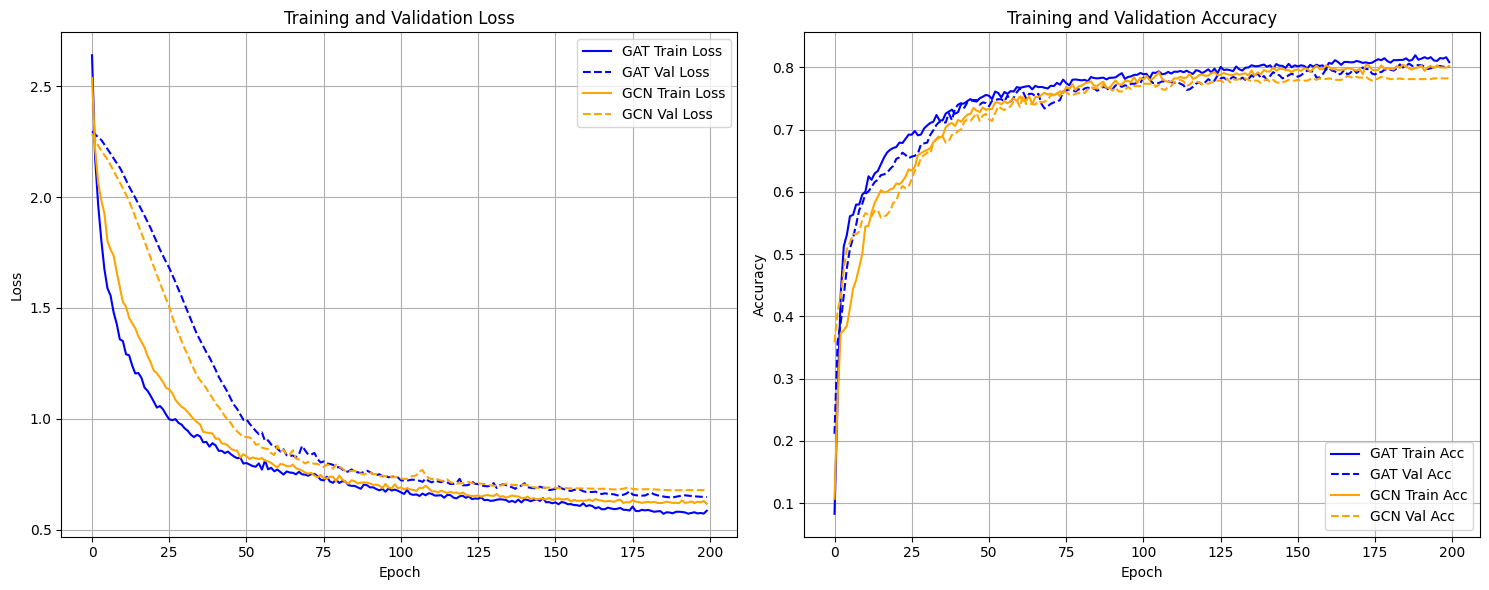

In [51]:
# Run training, saving, and plotting
train_save_and_plot() 

In [60]:
import torch

data = torch.load('all_graph_data/processed/data.pt', weights_only=False)
print(data)


Data(x=[8037, 1024], edge_index=[2, 120567], y=[8037], train_mask=[8037], val_mask=[8037], test_mask=[8037])


In [67]:
import pandas as pd

# Load metadata
metadata = pd.read_csv('nepali_music_metadata.csv')

# Create a mapping from class index to class name
class_mapping = dict(zip(metadata['class_id'], metadata['class_name']))

In [72]:
def predict_new_audio(audio_path):
    """
    Predict the class of a new audio file using the trained GNN model.
    
    Args:
        audio_path (str): Path to the audio file (30s WAV format).
    
    Returns:
        str: Predicted class name.
    """
    # Load YAMNet model (only once, cache it)
    if 'yamnet_model' not in globals():
        global yamnet_model
        yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
    
    # Load GNN model
    model = GAT(1024, 10) if MODEL_TYPE == 'gat' else GCN(1024, 10)
    model.load_state_dict(torch.load('best_GAT.pt'))
    model = model.to(DEVICE).eval()
    
    # Load existing data and normalization parameters
    data = torch.load(osp.join('all_graph_data/processed', 'data.pt'))
    norm_params = torch.load(osp.join('all_graph_data/processed', 'norm_params.pt'))
    
    try:
        # Step 1: Load and preprocess audio
        audio, sr = librosa.load(audio_path, sr=None, mono=True)
        if sr != 16000:  # Resample to YAMNet's expected sample rate
            audio = resampy.resample(audio, sr, 16000)
        
        # Step 2: Extract YAMNet features
        _, yamnet_embeddings, _ = yamnet_model(audio)
        new_feature = torch.tensor(np.mean(yamnet_embeddings.numpy(), axis=0), dtype=torch.float32)
        
        # Step 3: Normalize features using training data statistics
        new_feature = (new_feature - norm_params['min']) / (norm_params['max'] - norm_params['min'] + 1e-8)
        
        # Step 4: Move all tensors to the same device
        data.x = data.x.to(DEVICE)  # Move graph features to the same device as the model
        new_feature = new_feature.to(DEVICE)  # Ensure new feature is on the same device
        
        # Step 5: Create extended graph
        combined_features = torch.cat([data.x, new_feature.unsqueeze(0)])
        edge_index = knn_graph(combined_features, k=K)
        
        # Step 6: Make prediction
        with torch.no_grad():
            out = model(combined_features, edge_index)
            predicted_class_index = out[-1].argmax().item()
        
        # Step 7: Map class index to class name
        predicted_class_name = class_mapping.get(predicted_class_index, "Unknown")
        return predicted_class_name
    
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None  # Return None if inference fails

In [74]:
# Cell 7: Example Usage of Inference Function
audio_path = "sakela_test_023.wav"  # Replace with your audio file path
predicted_class = predict_new_audio(audio_path)

if predicted_class is not None:
    print(f"Predicted class index: {predicted_class}")
else:
    print("Failed to process the audio file.")

/tmp/ipykernel_13251/3477632411.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_GAT.pt'))
/tmp/ipykernel_13251/3477632411.py:22: 

Predicted class index: sakela
